In [1]:
import numpy as np
from sklearn.decomposition import PCA

In [2]:
import matplotlib.pyplot as plt

## PLSA Condicional (ejemplo 15.7)

Tenemos que implementar el algoritmo PLSA para el modelo x <- z <- y. Se trata simplemente del algoritmo 15.3 pero, como en el caso del algoritmo 15.2, la vectorización y garantizar que se trabaja con distribuciones de probabilidad oscurecen en el código la idea básica.

In [3]:
def plsaCond(pxgy, Z, opts):
    """
    Conditional PLSA Probabilistic Latent Semantic Analysis
    [tpxgz,tpygz,tpxgy]=plsa(pxgy,Z,opts)

    Entrada:
    pxgy : matriz con las frecuencias p(x|y)
    Z : dimensiones latentes/ocultas
    opts: diccionario con parámetros adicionales
    opts.maxit : número máximo de iteraciones
    opts.tol : tolerancia para convergir
    opts.randinit : vale 1 para una inicialización aleatoria -- en caso contrario, toma
     los valores de opts.tpxgz, opts.tpygz, opts.tpz

    Salida:
    tpxgz : aproximación de p(x|z)
    tpzgy : aproximación de p(z|y)
    tpxgy : aproximación de p(x|y)
    """

    # Cardinales de los conjuntos subyacentes
    X = pxgy.shape[0]
    Y = pxgy.shape[1]

    # Inicialización
    if opts["randinit"] == 1:
        #Inicialización con valroes random, las matrices se normalizan
        rng = np.random.default_rng()
        tpxgz = rng.random((X,Z))
        tpxgz = tpxgz / tpxgz.sum(axis=0)
        tpzgy = rng.random((Z,Y))
        tpzgy = tpzgy / tpzgy.sum(axis=0)
    else:
        tpxgz = opts["tpxgz"]
        tpzgy = opts["tpzgy"]

    eps = 1e-7  # para evitar divisiones entre cero
    L = np.zeros(opts["maxit"])  # verosimilitud
    qzgxy = np.zeros((Z, X, Y))

    for emloop in range(opts["maxit"]):
        tpxgy = np.zeros((X,Y)) + eps

        # Calcular tpxgy(para el modelo x <- z <- y)
        tpxgy = tpxgz @ tpzgy + eps

        # Log likelihood
        L[emloop] = np.sum(pxgy * np.log(tpxgy))

        # Paso E:
        for z in range(Z):
            qzgxy[z] = tpxgz[:,z].reshape(-1,1) * tpzgy[z]
        qzgxy /= qzgxy.sum(axis=0)

        # Paso M:
        for z in range(Z):
            tpxgz[:,z] = (pxgy * qzgxy[z]).sum(axis=1)
            tpzgy[z] = (pxgy * qzgxy[z]).sum(axis=0)

        # Normalizar
        tpxgz = tpxgz / tpxgz.sum(axis=0)
        tpzgy = tpzgy / tpzgy.sum(axis=0)

        # Criterio de parada
        if emloop > 1 and np.abs(L[emloop] - L[emloop-1]) < opts["tol"]:
            print(f"Converged after {emloop} iterations")
            break

    return tpxgz, tpzgy, tpxgy

Carga del conjunto de datos con las caras.

In [4]:
from sklearn.datasets import fetch_olivetti_faces

In [5]:
# Carga del conjunto de datos con las caras.
data = fetch_olivetti_faces()
images = data.images

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\nacho\scikit_learn_data


Altenativamente, se puede utilizar el conjunto de datos en los que las fotografías no han sido recortadas (los resultados son mejores con menos iteraciones). Para ello se puede utilizar el código de la celda siguiente, cargando las caras de los ficheros disponibles en el campus. Además, es importante tener en cuenta que las dimensiones de estas imágenes son 112x92 en vez de 64x64.

In [6]:
"""
images = np.zeros((400,112,92))

for i in range(40):
    for j in range(10):
        file = f'ORL/s{i+1}/{j+1}.pgm'
        with open(file, 'r', encoding='latin-1') as infile:
            header = infile.readline()
            header = infile.readline()
            header = infile.readline()
            width, height, maxval = 92, 112, 255
            images[i*10+j] = np.fromfile(infile, dtype=np.uint8).reshape((height, width))

images.shape
"""

"\nimages = np.zeros((400,112,92))\n\nfor i in range(40):\n    for j in range(10):\n        file = f'ORL/s{i+1}/{j+1}.pgm'\n        with open(file, 'r', encoding='latin-1') as infile:\n            header = infile.readline()\n            header = infile.readline()\n            header = infile.readline()\n            width, height, maxval = 92, 112, 255\n            images[i*10+j] = np.fromfile(infile, dtype=np.uint8).reshape((height, width))\n\nimages.shape\n"

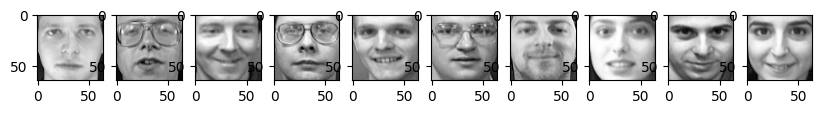

In [7]:
# Mostrar algunas de las caras.

fig, axs = plt.subplots(1, 10, figsize=(10,2))
for i in range(10):
    axs[i].imshow(images[i*10], cmap='gray')

Elegimos las caras que formarán la base.

In [8]:
basis = np.zeros((4,64,64))
basis[0] = images[0] / images[0].sum()
basis[1] = images[10] / images[10].sum()
basis[2] = images[60] / images[60].sum()
basis[3] = images[70] / images[70].sum()

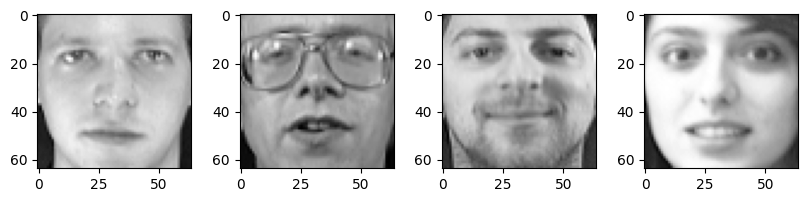

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(10,2))
for i in range(4):
    axs[i].imshow(basis[i], cmap='gray')

Creamos un conjunto de entrenamiento con 144 caras obtenidas mediante combinación convexa de las caras de la base.

In [10]:
train = np.zeros((144,64,64))

rng = np.random.default_rng()
for i in range(144):
    w = rng.random(4)
    w = w / w.sum() # garantizamos que sea distribución de probabilidad
    # train[i] = w[0]*basis[0] + w[1]*basis[1] + w[2]*basis[2] + w[3]*basis[3]
    train[i] = (w.reshape(4,1,1) * basis).sum(axis=0)

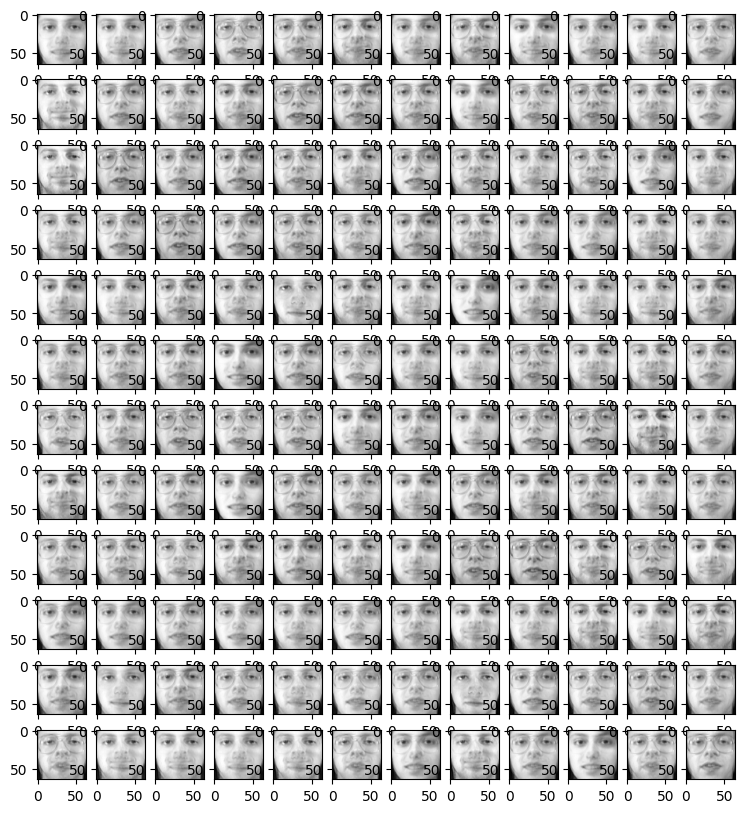

In [11]:
fig, axs = plt.subplots(12, 12, figsize=(9,10))
for i in range(12):
    for j in range(12):
        axs[i][j].imshow(train[i*12+j], cmap='gray')

Preparamos los datos de entrada para el algoritmo convirtiendo las matrices de las caras en vectores.

In [12]:
train_flat = train.reshape(144,4096)
pxgy = np.zeros((4096,144))
for i in range(144):
    pxgy[:,i] = train_flat[i]

In [13]:
# Definir los parámetros para las opciones
opts = {
    "maxit": 1000,  # Número máximo de iteraciones
    "tol": 1e-5,    # Tolerancia para la convergencia
    "randinit": 1   # Inicialización aleatoria
}

Z=4 # Número de dimensiones latentes

Queremos aplicar PLSA condicional para obtener las caras originales. En este contexto, recordando que estamos trabajando con un modelo x <- z <- y, ¿qué representan las siguientes variables y distribuciones?
- x: los píxeles de una imagen.
- z:  Patrones latentes (bases) que generan las imágenes
- y: Imágenes observadas generadas a partir de combinaciones de
𝑧.
- p(x|y): Distribución de píxeles dada una imagen (observada).
- p(x|z): Distribución de píxeles dado un patrón latente (base).
- p(z|y): Distribución de patrones latentes dado una imagen (cómo se mezclan las bases para generar la imagen).

In [14]:
tpxgz, tpzgy, tpxgy = plsaCond(pxgy,Z,opts)

Converged after 361 iterations


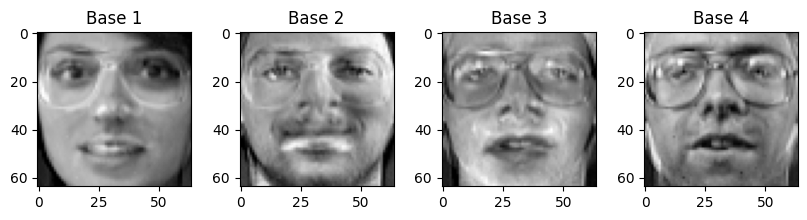

In [15]:
# Recuperar la base de tpxgz (dimensiones latentes -> imágenes)
recovered_basis = np.zeros((4, 64, 64))
for z in range(Z):
    recovered_basis[z] = tpxgz[:, z].reshape(64, 64)

# Visualizar las imágenes base recuperadas
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
for i in range(4):
    axs[i].imshow(recovered_basis[i], cmap='gray')
    axs[i].set_title(f"Base {i+1}")
plt.show()


El resultado mejora con 5000 iteraciones.

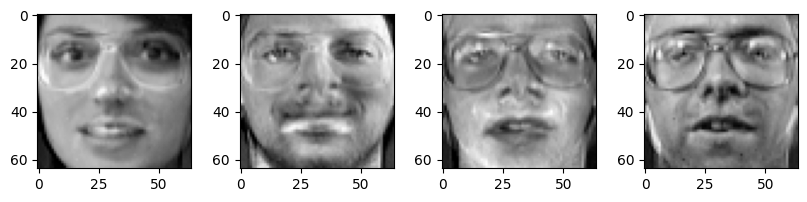

In [19]:
# 2000 iteraciones
fig, axs = plt.subplots(1, 4, figsize=(10,2))
for i in range(4):
    axs[i].imshow(recovered_basis[i], cmap='gray')

### Con SVD (PAC)

In [17]:
pca = PCA(n_components = 4)

trainD = pca.fit_transform(train_flat)
reducedX = trainD @ pca.components_

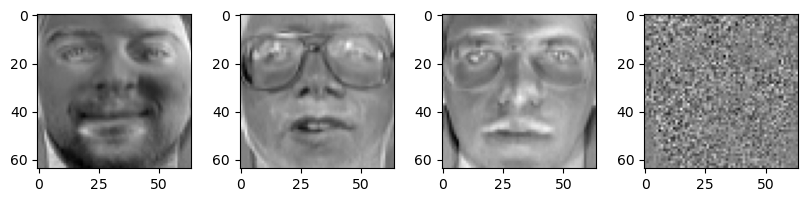

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(10,2))
for i in range(4):
    axs[i].imshow(pca.components_[i].reshape(64,64)+train.mean(axis=0), cmap='gray')

# Ejercicio.
Vamos a comparar los resultados obtenidos con PLSA y PCA. Cuando acabes, comenta en la siguiente celda las diferencias que observas, a qué pueden deberse, ventajas y desventajas de cada método...

### Comparación entre PLSA y PCA

1. **Calidad de la Reconstrucción**:
   - **PLSA**: Produce imágenes más nítidas y con mejor resolución. Esto se debe a que PLSA utiliza un modelo probabilístico que capta mejor las características latentes de las imágenes y las relaciones entre los píxeles.
   - **PCA**: A menudo genera imágenes menos nítidas. PCA se basa en la varianza de los datos y puede perder detalles importantes en la proyección de las imágenes, especialmente cuando se utilizan un número limitado de componentes principales.

2. **Interpretación de Resultados**:
   - **PLSA**: Ofrece una interpretación más rica debido a su enfoque probabilístico. Se centra en la relación entre las características (píxeles) y las clases ocultas, lo que permite recuperar las estructuras de los datos de manera más eficiente.
   - **PCA**: Se centra en las direcciones de máxima varianza y puede no capturar adecuadamente las características latentes que son importantes para la clasificación o recuperación de imágenes.

3. **Ventajas y Desventajas**:
   - **PLSA**:
     - Ventajas:
       - Mejor para la recuperación de datos con ruido y para estructuras complejas.
       - Capacidad de modelar distribuciones más flexibles.
     - Desventajas:
       - Requiere un mayor tiempo de cómputo y una buena inicialización.
       - Puede ser más complicado de implementar y entender.

   - **PCA**:
     - Ventajas:
       - Método más simple y rápido de implementar.
       - Eficaz para reducir la dimensionalidad y para datos que siguen distribuciones gaussianas.
     - Desventajas:
       - Puede resultar en la pérdida de información crítica, especialmente en datos no lineales.
       - La calidad de la reconstrucción puede ser muy variable, como se observó en este caso.

En resumen, PLSA puede ser más adecuado para la recuperación de imágenes de caras debido a su capacidad para capturar la complejidad de los datos y producir resultados más nítidos y coherentes. Por otro lado, PCA, aunque más sencillo y rápido, puede no ser suficiente para aplicaciones que requieren una alta calidad de reconstrucción.



### Comparación con PCA (ejemplo 15.2)

Creamos un conjunto de prueba de tamaño 100 escogiendo 3 caras de cada persona.

In [19]:
train_pca = np.zeros((100,64,64))
for i in range(33):
    train_pca[i*3] = images[i*10]
    train_pca[i*3+1] = images[i*10+1]
    train_pca[i*3+2] = images[i*10+2]
train_pca[99] = images[330]

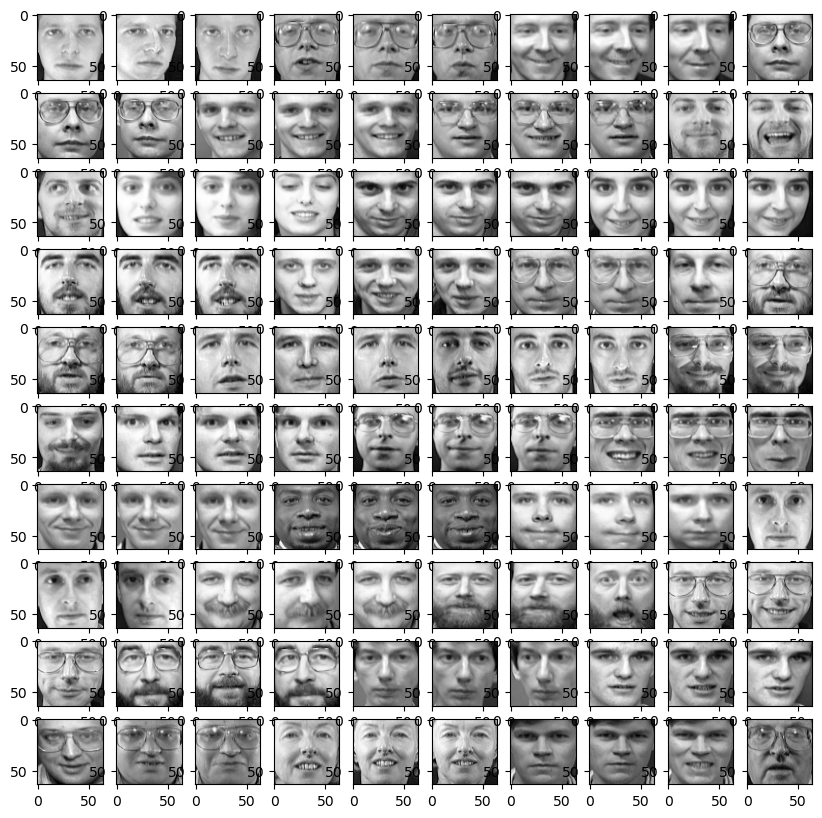

In [20]:
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i][j].imshow(train_pca[i*10+j].reshape(64,64), cmap='gray')

In [21]:
pca = PCA(n_components = 48)
trainD = pca.fit_transform(train_pca.reshape(100,4096))
reducedX = trainD @ pca.components_

Dibujamos las "autocaras".

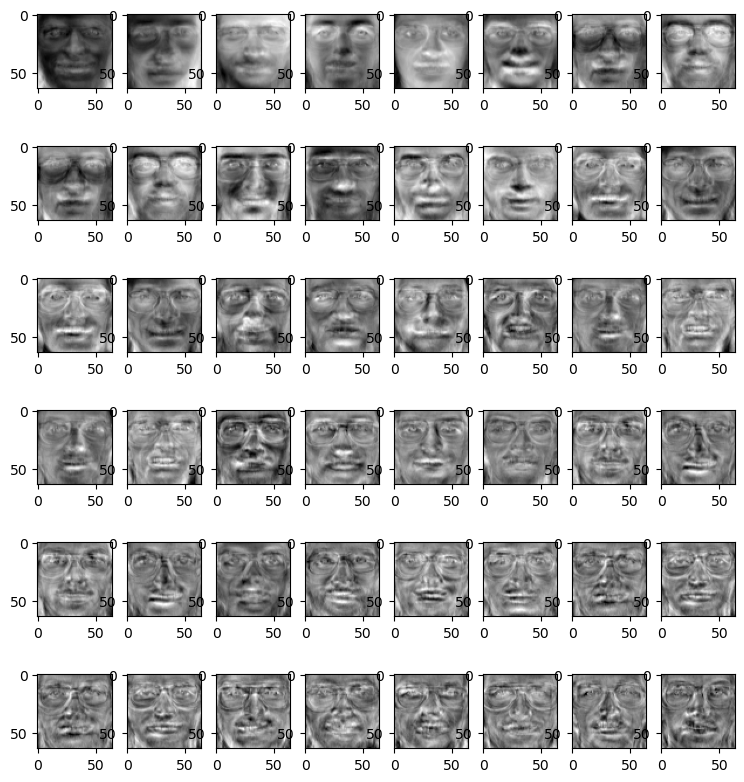

In [22]:
fig, axs = plt.subplots(6, 8, figsize=(9,10))
for i in range(6):
    for j in range(8):
        axs[i][j].imshow(pca.components_[i*6+j].reshape(64,64), cmap='gray')

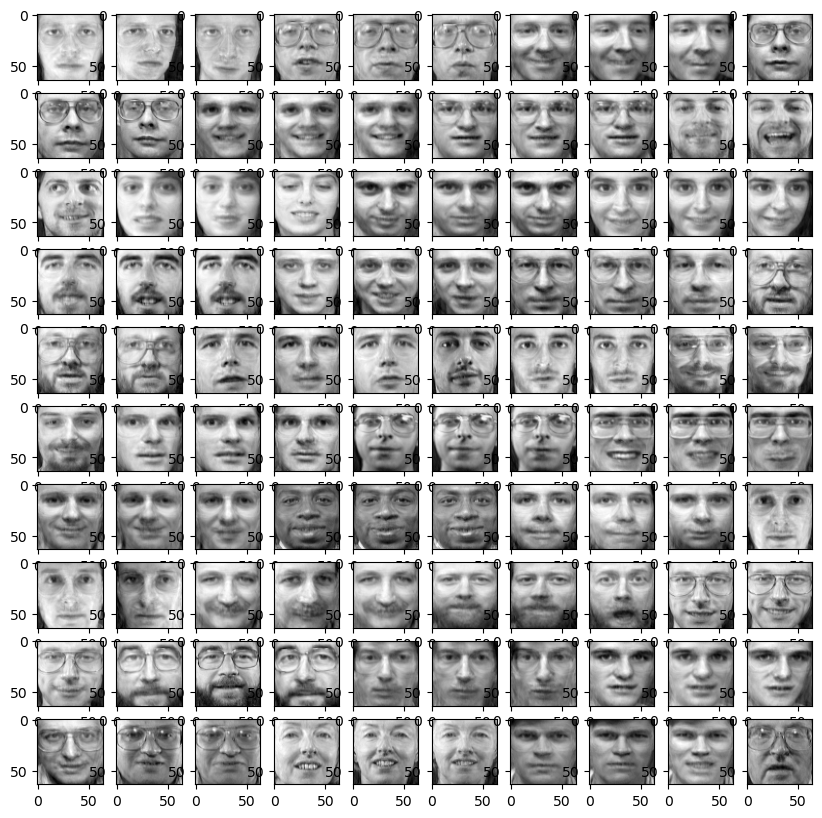

In [23]:
# Reconstrucción con la media y las 48 autocaras.

fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i][j].imshow(reducedX[i*10+j].reshape(64,64)+train_pca.mean(axis=0), cmap='gray')

Calculamos los 48 elementos de la base con PLSA.

In [24]:
opts = {"tol" : 0.0000001,
        "plotprogress" : 0,
        "maxit" : 100,
        "randinit" : 1
       }
Z=48

Se puede experimentar con el número de iteraciones. (Los resultados mostrados requirieron 10 minutos en ordenador de hace 8 años para 2000 iteraciones.)

In [25]:
pxgy = train_pca.reshape(100,4096).T
tpxgz, tpzgy, tpxgy = plsaCond(pxgy,Z,opts)

Dibujamos las "autocaras" obtenidas con PLSA.

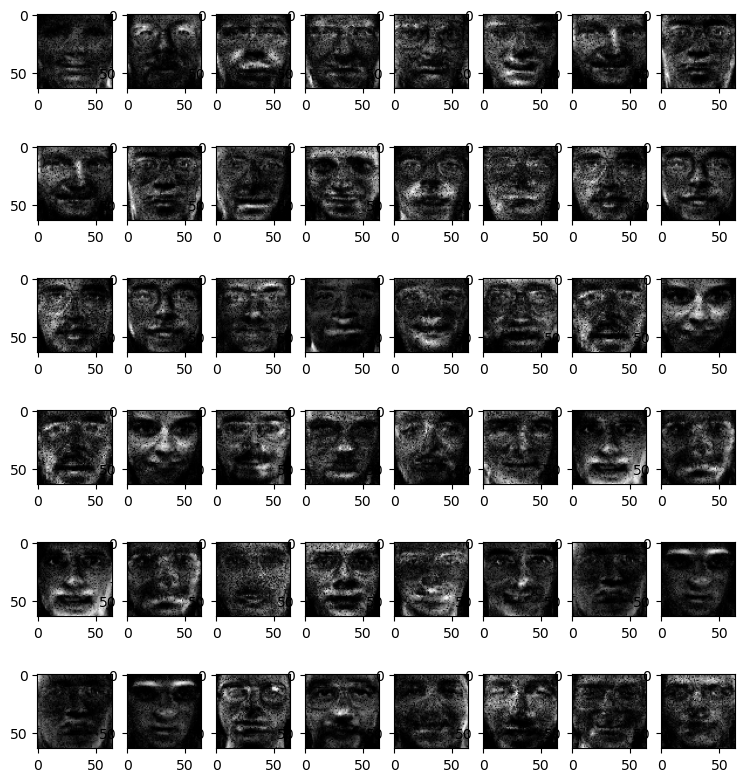

In [26]:
fig, axs = plt.subplots(6, 8, figsize=(9,10))
for i in range(6):
    for j in range(8):
        axs[i][j].imshow(tpxgz[:,i*6+j].reshape(64,64), cmap='gray')

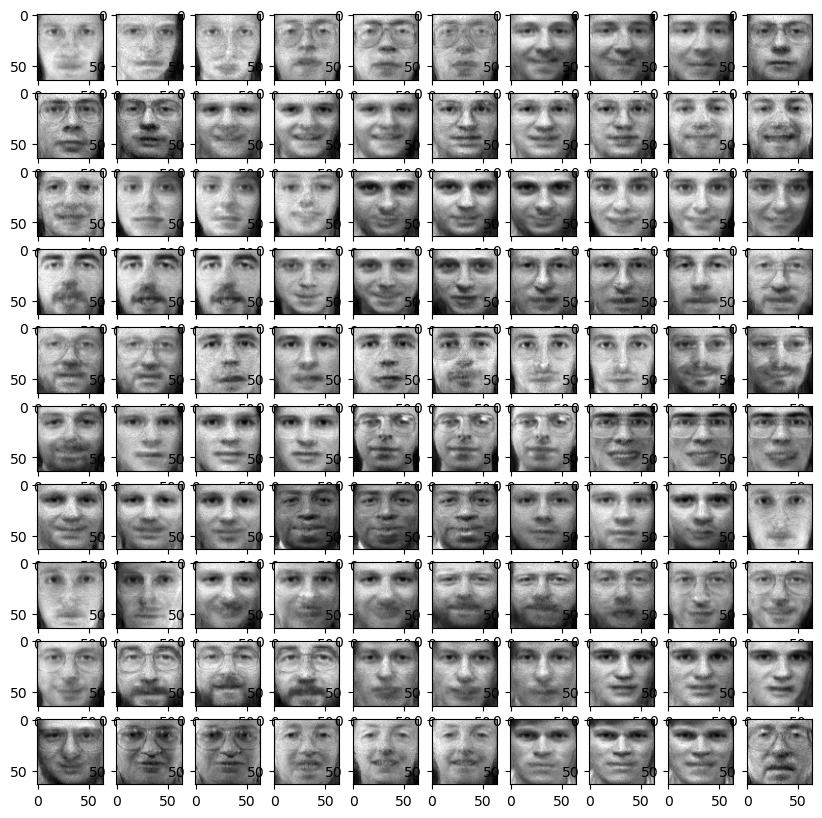

In [27]:
# Reconstrucción con las 48 autocaras de PLSA.

fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i][j].imshow(tpxgy[:,i*10+j].reshape(64,64), cmap='gray')

### Ejercicio Opcional Comparación de Resultados: PCA vs PLSA

#### Interpretabilidad de los Temas:
- **PLSA**: 
  - PLSA ofrece temas más interpretables porque modela explícitamente las relaciones probabilísticas entre las características (píxeles) y las variables latentes (temas). 
  - Los temas en PLSA representan combinaciones de características recurrentes en las imágenes, lo que permite una mejor interpretación de los componentes latentes.
  - Los resultados de PLSA reflejan una separación más clara de las estructuras latentes en los datos, por lo que las caras reconstruidas se perciben con mayor detalle y nitidez.

- **PCA**:
  - En PCA, los temas (componentes principales) corresponden a las direcciones de máxima varianza en los datos, pero estos componentes no necesariamente tienen una interpretación clara en términos de características humanas o faciales.
  - Las imágenes resultantes suelen ser más difusas, lo que hace que los temas sean menos interpretables.
  - El enfoque de PCA tiende a mezclar varias características en los primeros componentes, lo que dificulta la identificación de temas específicos o relevantes.

#### Causas de las Diferencias:
- **PLSA** es un modelo probabilístico que captura la relación entre píxeles y clases latentes (temas), mientras que **PCA** es un método lineal basado en la varianza que no tiene en cuenta esta estructura latente. 
- PLSA se enfoca en maximizar la probabilidad de los datos dados los temas ocultos, lo que permite modelar con mayor precisión las relaciones entre píxeles. Esto conduce a una reconstrucción más clara de las imágenes, especialmente cuando los datos tienen una estructura compleja o no lineal.
- PCA, al basarse en la varianza, puede no capturar de manera efectiva las características importantes en datos de alta dimensión o con muchas correlaciones entre las variables.

#### Ventajas y Desventajas:
- **PLSA**:
  - **Ventajas**: Produce temas más interpretables y representaciones más claras de las imágenes. Ideal para datos con estructuras latentes complejas.
  - **Desventajas**: Requiere más tiempo de cómputo y puede ser más sensible a la inicialización y los parámetros.

- **PCA**:
  - **Ventajas**: Simplicidad y rapidez de implementación, eficiente para la reducción de dimensionalidad en datos con estructura gaussiana.
  - **Desventajas**: Menor interpretabilidad de los componentes y pérdida de detalles importantes en la reconstrucción de imágenes.

#### Conclusión:
En tareas de análisis de imágenes como esta, donde la relación entre características es compleja y no lineal, **PLSA** parece ofrecer resultados más apropiados e interpretables que **PCA**. La naturaleza probabilística de PLSA le permite capturar temas latentes de manera más efectiva, lo que se traduce en una mayor nitidez y coherencia en las imágenes reconstruidas.
